In [33]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
# Set the default figure size
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [35]:
# Set the default figure size
class MyDataset(Dataset):
    def __init__(self, filepath):
        df = pd.read_csv(filepath, index_col=0)
        arr = df.values
        arr = arr.astype(np.float32)
        ts = torch.tensor(arr)
        self.X = ts[:, :-1].to('mps')
        self.y = ts[:, -1].reshape(-1, 1).to('mps')
        self.len = ts.shape[0]
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [36]:
# Load the data
data = MyDataset('Data.csv')
train_size = int(0.7 * len(data))
test_size = len(data) - train_size
train_data, test_data = random_split(data, [train_size, test_size])

In [37]:
# Create the data loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [38]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 32),
            nn.Sigmoid(),
            nn.Linear(32, 8),
            nn.Sigmoid(),
            nn.Linear(8, 4),
            nn.Sigmoid(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [39]:
model = DNN().to('mps')

In [40]:
loss_fn = nn.BCELoss(reduction='mean')

In [41]:
leaning_rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=leaning_rate)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:16<00:00, 30.27it/s]


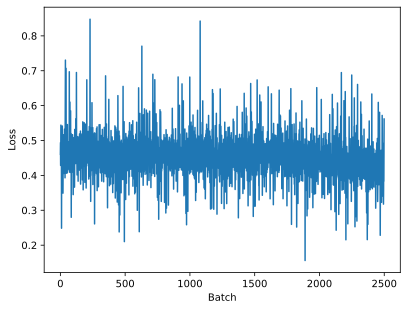

In [43]:
from tqdm import *

epochs = 500
losses = []

for epoch in trange(epochs):
    for x, y in train_loader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()


In [45]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader:
        y_pred = model(x)
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        correct += (y_pred == y).sum().item()
        total += y.size(0)

print(f'Accuracy: {correct / total * 100:.2f}%')

Accuracy: 79.82%
